# Homework 2: Segmantic Segmentation with ConvNets 

In [1]:
# All necessary imports for the project:
import os
import numpy as np
import skimage
import skimage.data
import skimage.io
from pathlib import Path
import albumentations as A

# Matplotlib for visualization
from matplotlib import pyplot as plt
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [5, 5]

# TensorFlow and parameters:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
import tensorflow as tf
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
import warnings

# Ignore warnings
warnings.filterwarnings('ignore')

# Used for wandb logging:
import wandb
from wandb.keras import WandbCallback
API_KEY="83f8caad19a7dda51610e1c52dc656bb5472d3eb"
wandb.login(key=API_KEY)


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 11218934816437495420
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 22319988736
locality {
  bus_id: 1
  links {
  }
}
incarnation: 9657199116731624519
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:01:00.0, compute capability: 8.9"
xla_global_id: 416903419
]


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: shushack-net (dennisshush). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/tfuser/.netrc


True

## Exercise: This part shows the entire code for the exercise

The Preprocessor class in the provided code is designed to handle the pre-processing of image data for the convolutional networks. It performs:
- Min-Max normalization of the image data
- One-hot encoding of the labels
- Data shuffling, batching and the creation of tensorflow datasets

In [3]:
class Preprocessor(): 
    """
    This class is in charge of pre-processing the data and making 
    it suitable for the model.
    path: path to the directory containing the images and labels
    batch_size: batch size for training 
    num_classes: number of classes in the dataset (34 for this project)
    patch_size_width: width of the patches (256)
    patch_size_height: height of the patches (256)
    file_type_str: 'train', 'test', or 'validate'
    border: border size
    channels: number of channels (3 for RGB)     
    """
    def __init__(self,
                 path,
                 batch_size,
                 num_classes, 
                 patch_size_width, 
                 patch_size_height,
                 file_type_str,
                 border=0, 
                 channels=3
                 ):
        
        self.path = path + file_type_str + '/'
        self.batch_size = batch_size
        self.border = border
        self.num_classes = num_classes
        self.patch_size_width = patch_size_width
        self.patch_size_height = patch_size_height
        self.file_type_str = file_type_str
        self.channels = channels
        self.dataset = None

        print(f"Preprocessing the {self.file_type_str} data...")

    def create_dataset(self):
        # Get a list of the files:
        path = Path(self.path)
        image_files = list(path.glob(self.file_type_str+'_img*.png'))
        label_files = list(path.glob(self.file_type_str+'_lbl*.png'))

        # Sort the files: 
        image_files.sort()
        label_files.sort()

        # Check if we have an equal number of images and labels:
        if len(image_files) != len(label_files):
            raise ValueError('The number of images and labels does not match.')

        # Read the images and label file_directories into a numpy array:
        image_files_array = np.asarray([str(p) for p in image_files])
        label_files_array = np.asarray([str(p) for p in label_files])
      
        # Create a dataset from the file_directories:
        self.dataset = tf.data.Dataset.from_tensor_slices((image_files_array, label_files_array))
        self.dataset = self.dataset.shuffle(buffer_size=10000)

        self.dataset = self.dataset.map(lambda image, file:
                        self._parse_function(image, file))

        # Parse the images and labels to the correct form:
        self.dataset = self.dataset.map(lambda x, y:
                        (tf.reshape(x, shape=(self.patch_size_width, self.patch_size_height, 3)),
                        tf.reshape(y, shape=(self.patch_size_width, self.patch_size_height))))
        
        # cut center of the label image in order to use valid filtering in the network
        b = self.border
        if b != 0:
            self.dataset = self.dataset.map(lambda x, y:
                                    (x, y[b:-b, b:-b]))
        
        # We one-hot encode the labels:
        self.dataset = self.dataset.map(lambda x, y: (x, tf.one_hot(y, depth=self.num_classes, dtype=tf.float32)))

        print("Done preprocessing the data.")

        return self.dataset, image_files_array.size


    def _parse_function(self, image_filename, label_filename):
        """
        This function reads the image and label files and returns the
        image and label tensors.
        """

        # Read the image and label into a tensor:
        image_string = tf.io.read_file(image_filename)
        label_string = tf.io.read_file(label_filename)

        # Decode the image and label:
        image = tf.image.decode_png(image_string, channels=self.channels)
        label = tf.image.decode_png(label_string, channels=1)

        # Convert the image and label to float32:
        image = tf.cast(image, tf.float32)
        label = tf.cast(label, tf.float32)

        # Min-max normalization:
        image_min = tf.reduce_min(image)
        image_max = tf.reduce_max(image)
        image = (image - image_min)/(image_max - image_min + 1e-7)

        # Decode label:
        label = tf.image.decode_png(label_string, dtype=tf.uint8, channels=1)
        return image, label


# We define the simple FCN model here

In [4]:
from tensorflow.keras import layers, models

def build_simple_fcn(input_shape, num_classes):
    model = models.Sequential()    


    model.add(layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same', strides=(1,1), input_shape=input_shape))
    model.add(layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same', strides=(1,1)))
    model.add(layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same', strides=(1,1)))

    model.add(layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same', strides=(1,1)))
    model.add(layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same', strides=(1,1)))
    model.add(layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same', strides=(1,1)))

    # Output layer
    model.add(layers.Convolution2D(filters=num_classes, kernel_size=1, activation=None, padding="same", strides=(1,1)))
    model.add(layers.Activation('softmax'))


    return model

# Wandb: 
wandb.tensorboard.patch(root_logdir=log_dir)

wandb.init(project="simple_fcn")


# Execution of Simple FCN: 
DIR_PATH = './data/'
BATCH_SIZE = 32
NUM_CLASSES = 34 # Update with the actual number of your classes
PATCH_SIZE_WIDTH, PATCH_SIZE_HEIGHT = 256, 256  # Adjust sizes as needed
DIR_STR = ['train', 'test', 'val']
BORDER = 0


preprocessor_train = Preprocessor(DIR_PATH, BATCH_SIZE, NUM_CLASSES, PATCH_SIZE_WIDTH, PATCH_SIZE_HEIGHT, DIR_STR[0], BORDER, 3)

# Create the training dataset:
dataset_train, nr_images_train = preprocessor_train.create_dataset()
dataset_train = dataset_train.batch(BATCH_SIZE).repeat()

# Create the test dataset:
preprocessor_test = Preprocessor(DIR_PATH, BATCH_SIZE, NUM_CLASSES, PATCH_SIZE_WIDTH, PATCH_SIZE_HEIGHT, DIR_STR[1], BORDER, 3)
dataset_test, nr_images_test = preprocessor_test.create_dataset()
dataset_test = dataset_test.batch(BATCH_SIZE).repeat()

# Create the validation dataset:
preprocessor_val = Preprocessor(DIR_PATH, BATCH_SIZE, NUM_CLASSES, PATCH_SIZE_WIDTH, PATCH_SIZE_HEIGHT, DIR_STR[2], BORDER, 3)
dataset_val, nr_images_val = preprocessor_val.create_dataset()
dataset_val = dataset_val.batch(BATCH_SIZE)

# Define input shape
input_shape = (PATCH_SIZE_WIDTH, PATCH_SIZE_HEIGHT, 3)

# Build the model
model = build_simple_fcn(input_shape, NUM_CLASSES)
model.summary()

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(dataset_train,
                    steps_per_epoch=nr_images_train // BATCH_SIZE,
                    epochs=10,  # Set the number of epochs
                    validation_data=dataset_val,
                    validation_steps=nr_images_val // BATCH_SIZE,
                    callbacks=[WandbCallback()])

# Evaluate the model
test_loss, test_accuracy = model.evaluate(dataset_test, steps=nr_images_test // BATCH_SIZE)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")



Preprocessing the train data...
Done preprocessing the data.
Preprocessing the test data...
Done preprocessing the data.
Preprocessing the val data...
Done preprocessing the data.
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 256, 256, 32)      9248      
                                                                 
 conv2d_2 (Conv2D)           (None, 256, 256, 32)      9248      
                                                                 
 conv2d_3 (Conv2D)           (None, 256, 256, 64)      18496     
                                                                 
 conv2d_4 (Conv2D)           (None, 256, 256, 64)      36928     
                                                                 
 conv2d_

wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.


Epoch 1/10
122/122 [==============================] - ETA: 0s - loss: 2.1995 - accuracy: 0.3520INFO:tensorflow:Assets written to: /workspaces/HW2CompVIs/wandb/run-20240109_153936-d62zhon7/files/model-best/assets


INFO:tensorflow:Assets written to: /workspaces/HW2CompVIs/wandb/run-20240109_153936-d62zhon7/files/model-best/assets
wandb: Adding directory to artifact (/workspaces/HW2CompVIs/wandb/run-20240109_153936-d62zhon7/files/model-best)... Done. 0.0s


122/122 [==============================] - 33s 219ms/step - loss: 2.1995 - accuracy: 0.3520 - val_loss: 2.3763 - val_accuracy: 0.3540
Epoch 2/10
122/122 [==============================] - 25s 207ms/step - loss: 1.8504 - accuracy: 0.4328 - val_loss: 2.4096 - val_accuracy: 0.3626
Epoch 3/10
122/122 [==============================] - ETA: 0s - loss: 1.7353 - accuracy: 0.4762INFO:tensorflow:Assets written to: /workspaces/HW2CompVIs/wandb/run-20240109_153936-d62zhon7/files/model-best/assets


INFO:tensorflow:Assets written to: /workspaces/HW2CompVIs/wandb/run-20240109_153936-d62zhon7/files/model-best/assets
wandb: Adding directory to artifact (/workspaces/HW2CompVIs/wandb/run-20240109_153936-d62zhon7/files/model-best)... Done. 0.0s


122/122 [==============================] - 26s 211ms/step - loss: 1.7353 - accuracy: 0.4762 - val_loss: 2.2700 - val_accuracy: 0.3913
Epoch 4/10
122/122 [==============================] - ETA: 0s - loss: 1.6659 - accuracy: 0.4920INFO:tensorflow:Assets written to: /workspaces/HW2CompVIs/wandb/run-20240109_153936-d62zhon7/files/model-best/assets


INFO:tensorflow:Assets written to: /workspaces/HW2CompVIs/wandb/run-20240109_153936-d62zhon7/files/model-best/assets
wandb: Adding directory to artifact (/workspaces/HW2CompVIs/wandb/run-20240109_153936-d62zhon7/files/model-best)... Done. 0.0s


122/122 [==============================] - 27s 218ms/step - loss: 1.6659 - accuracy: 0.4920 - val_loss: 2.2518 - val_accuracy: 0.4046
Epoch 5/10
122/122 [==============================] - ETA: 0s - loss: 1.6287 - accuracy: 0.5033INFO:tensorflow:Assets written to: /workspaces/HW2CompVIs/wandb/run-20240109_153936-d62zhon7/files/model-best/assets


INFO:tensorflow:Assets written to: /workspaces/HW2CompVIs/wandb/run-20240109_153936-d62zhon7/files/model-best/assets
wandb: Adding directory to artifact (/workspaces/HW2CompVIs/wandb/run-20240109_153936-d62zhon7/files/model-best)... Done. 0.0s


122/122 [==============================] - 27s 225ms/step - loss: 1.6287 - accuracy: 0.5033 - val_loss: 2.2253 - val_accuracy: 0.4388
Epoch 6/10
122/122 [==============================] - 26s 218ms/step - loss: 1.6157 - accuracy: 0.5046 - val_loss: 2.3908 - val_accuracy: 0.3288
Epoch 7/10
122/122 [==============================] - 26s 218ms/step - loss: 1.5739 - accuracy: 0.5206 - val_loss: 2.2315 - val_accuracy: 0.4330
Epoch 8/10
122/122 [==============================] - ETA: 0s - loss: 1.5494 - accuracy: 0.5289INFO:tensorflow:Assets written to: /workspaces/HW2CompVIs/wandb/run-20240109_153936-d62zhon7/files/model-best/assets


INFO:tensorflow:Assets written to: /workspaces/HW2CompVIs/wandb/run-20240109_153936-d62zhon7/files/model-best/assets
wandb: Adding directory to artifact (/workspaces/HW2CompVIs/wandb/run-20240109_153936-d62zhon7/files/model-best)... Done. 0.0s


122/122 [==============================] - 27s 224ms/step - loss: 1.5494 - accuracy: 0.5289 - val_loss: 2.2050 - val_accuracy: 0.4246
Epoch 9/10
122/122 [==============================] - ETA: 0s - loss: 1.5244 - accuracy: 0.5392INFO:tensorflow:Assets written to: /workspaces/HW2CompVIs/wandb/run-20240109_153936-d62zhon7/files/model-best/assets


INFO:tensorflow:Assets written to: /workspaces/HW2CompVIs/wandb/run-20240109_153936-d62zhon7/files/model-best/assets
wandb: Adding directory to artifact (/workspaces/HW2CompVIs/wandb/run-20240109_153936-d62zhon7/files/model-best)... Done. 0.0s


122/122 [==============================] - 26s 217ms/step - loss: 1.5244 - accuracy: 0.5392 - val_loss: 2.1380 - val_accuracy: 0.4713
Epoch 10/10
59/59 [==============================] - 3s 56ms/step - loss: 2.2531 - accuracy: 0.3905
Test Loss: 2.2531259059906006, Test Accuracy: 0.39045825600624084


## Complicated Model UNET:

* UNET is a fully convolutional network that is used for semantic segmentation. It's goal is to predict each pixel's class. 
* UNET is built upon a FCN architecture which consists of an encoder and decoder. It contains skip connections between the encoder and decoder to preserve spatial information.

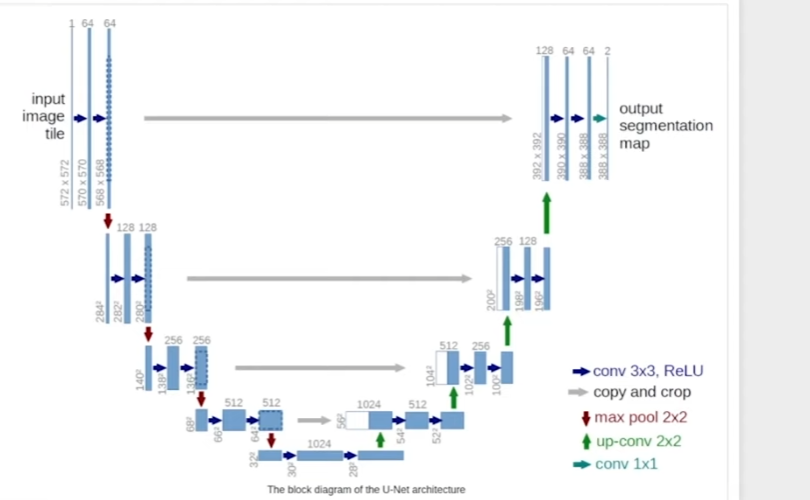

In [12]:
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input
from tensorflow.keras import Model


def conv_block(inputs, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

def encoder_block(inputs, num_filters):
    x = conv_block(inputs, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p

def decoder_block(inputs, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(inputs)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

def build_unet(input_shape, num_classes):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    b1 = conv_block(p4, 1024)

    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    outputs = Conv2D(num_classes, 1, padding="same", activation="softmax")(d4)

    model = Model(inputs, outputs, name="U-Net")
    return model




<KerasTensor: shape=(None, 256, 256, 32) dtype=float32 (created by layer 'activation_2')>

In [30]:
from tensorflow.keras import layers, models
import wandb
from wandb.keras import WandbCallback


def build_unet_like_model(input_shape, num_classes):
   


# Data paths and parameters
DIR_PATH = './data/'
BATCH_SIZE = 32
NUM_CLASSES = 34  # Update with the actual number of your classes
PATCH_SIZE_WIDTH, PATCH_SIZE_HEIGHT = 256, 256  # Adjust sizes as needed
DIR_STR = ['train', 'test', 'val']
BORDER = 0

# Data preprocessing
preprocessor_train = Preprocessor(DIR_PATH, BATCH_SIZE, NUM_CLASSES, PATCH_SIZE_WIDTH, PATCH_SIZE_HEIGHT, DIR_STR[0], BORDER, 3)
dataset_train, nr_images_train = preprocessor_train.create_dataset()
dataset_train = dataset_train.batch(BATCH_SIZE).repeat()

preprocessor_test = Preprocessor(DIR_PATH, BATCH_SIZE, NUM_CLASSES, PATCH_SIZE_WIDTH, PATCH_SIZE_HEIGHT, DIR_STR[1], BORDER, 3)
dataset_test, nr_images_test = preprocessor_test.create_dataset()
dataset_test = dataset_test.batch(BATCH_SIZE).repeat()

preprocessor_val = Preprocessor(DIR_PATH, BATCH_SIZE, NUM_CLASSES, PATCH_SIZE_WIDTH, PATCH_SIZE_HEIGHT, DIR_STR[2], BORDER, 3)
dataset_val, nr_images_val = preprocessor_val.create_dataset()
dataset_val = dataset_val.batch(BATCH_SIZE)

# Define input shape
input_shape = (PATCH_SIZE_WIDTH, PATCH_SIZE_HEIGHT, 3)

# Initialize wandb
wandb.init(project="your_segmentation_project", entity="your_wandb_username")
wandb.config = {
    "learning_rate": 0.001,
    "epochs": 10,
    "batch_size": BATCH_SIZE,
    "num_classes": NUM_CLASSES,
}

# Build and compile the model
model = build_unet_like_model(input_shape, wandb.config.num_classes)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    dataset_train,
    steps_per_epoch=nr_images_train // wandb.config.batch_size,
    epochs=wandb.config.epochs,
    validation_data=dataset_val,
    validation_steps=nr_images_val // wandb.config.batch_size,
    callbacks=[WandbCallback()]
)

# Evaluate the model
test_loss, test_accuracy = model.evaluate(dataset_test, steps=nr_images_test // wandb.config.batch_size)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

# Log test results to wandb
wandb.log({'test_loss': test_loss, 'test_accuracy': test_accuracy})

# Finish wandb run
wandb.finish()


Preprocessing the train data...
Done preprocessing the data.
Preprocessing the test data...
Done preprocessing the data.
Preprocessing the val data...
Done preprocessing the data.


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: